<a href="https://colab.research.google.com/github/Simsonsg/ARI3212-Advanced-Reinforcement-Learning/blob/main/Experiment_2_OnPolicy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install swig
!pip install gymnasium[box2d]

In [ ]:
!pip install renderlab

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import AdamW
import numpy as np
import copy
from collections import deque
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv
from gymnasium.vector import SyncVectorEnv
from itertools import count
import matplotlib.pyplot as plt

In [ ]:
env_name = 'LunarLanderContinuous-v3'

In [ ]:
# ActorCritic Network for Continuous Actions
# LunarLanderContinuous has 2 continuous actions in [-1, 1]
class ActorCriticNet(nn.Module):
    def __init__(self, input_size, hidden_units=256, n_actions=2):
        super(ActorCriticNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU()
        )
        # Actor outputs mean for each action dimension
        self.actor_mean = nn.Linear(hidden_units, n_actions)
        # Learnable log standard deviation
        self.actor_log_std = nn.Parameter(torch.zeros(1, n_actions))
        # Value head
        self.value_head = nn.Linear(hidden_units, 1)

    def forward(self, x):
        x = self.model(x)
        # Action mean scaled to [-1, 1] via tanh
        action_mean = torch.tanh(self.actor_mean(x))
        # Standard deviation (softplus ensures positive, clamped for stability)
        action_std = torch.clamp(F.softplus(self.actor_log_std), min=0.1, max=1.0).expand_as(action_mean)
        value = self.value_head(x)
        return action_mean, action_std, value

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def make_env():
    return gym.make(env_name)

# Create the vectorized environment
num_envs = 8
env = AsyncVectorEnv([make_env for _ in range(num_envs)])

In [ ]:
obs_dim = env.single_observation_space.shape[0]
n_actions = env.single_action_space.shape[0]
print(f"Observation dim: {obs_dim}, Action dim: {n_actions}")

Observation dim: 8, Action dim: 2


In [ ]:
# Actor-Critic network
hidden_sizes = 256
ac_net = ActorCriticNet(obs_dim, hidden_sizes, n_actions)
ac_net = ac_net.apply(initialize_weights)

In [ ]:
# optimizer
optimizer = AdamW(ac_net.parameters(), lr=3e-4)

In [ ]:
T = lambda x: torch.as_tensor(x, dtype=torch.float32)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64)

In [ ]:
@torch.no_grad()
def run_test(trajectories, policy, render=False):
    env2 = gym.make(env_name, render_mode="rgb_array")
    if render:
        import renderlab as rl
        env2 = rl.RenderFrame(env2, "./video")
    scores = []
    for trajectory in range(trajectories):
        trajectory_return = 0
        obs, _ = env2.reset()
        done = False
        while not done:
            with torch.no_grad():
                action_mean, _, _ = policy(T(obs).unsqueeze(0))
            # Use mean action (deterministic) for evaluation
            action = action_mean.squeeze(0).numpy()
            next_obs, reward, terminated, truncated, _ = env2.step(action)
            done = terminated or truncated
            obs = next_obs
            trajectory_return += reward
        scores.append(trajectory_return)
    if render:
        env2.play()
    del env2
    return np.mean(scores)

In [ ]:
results = deque(maxlen=50)
gamma = 0.99
nsteps = 64
entropy_coef = 0.01
value_coef = 0.5
timesteps_log = []
rewards_log = []
total_timesteps = 0

obs, _ = env.reset()
for epoch in count():
    for steps in range(nsteps):
        action_mean, action_std, state_value = ac_net(T(obs))

        # Create normal distribution for continuous actions
        dist = Normal(loc=action_mean, scale=action_std)
        action = dist.sample()
        # Clamp action to valid range [-1, 1]
        action_clamped = torch.clamp(action, -1.0, 1.0)

        next_obs, reward, terminated, truncated, _ = env.step(action_clamped.numpy())
        done = terminated | truncated
        total_timesteps += 1

        _, _, next_state_value = ac_net(T(next_obs))
        next_state_value[done] = 0.0
        target = T(reward).unsqueeze(1) + gamma * next_state_value

        optimizer.zero_grad()
        value_loss = F.smooth_l1_loss(target, state_value)
        advantage = (target - state_value).detach()
        advantage = (advantage - torch.mean(advantage)) / (torch.std(advantage) + 1e-8)

        # Sum log probs across action dimensions
        log_prob = dist.log_prob(action).sum(dim=-1, keepdim=True)
        entropy = dist.entropy().sum(dim=-1, keepdim=True)
        policy_loss = -(log_prob * advantage).mean() - entropy_coef * entropy.mean()

        total_loss = policy_loss + value_coef * value_loss
        total_loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(ac_net.parameters(), 0.5)
        optimizer.step()

        obs = next_obs

    # Run test episode
    results.append(run_test(1, ac_net))
    score = np.mean(results)

    timesteps_log.append(total_timesteps)
    rewards_log.append(score)

    if epoch > 1 and epoch % 25 == 0:
        print(f'epoch: {epoch} \t return: {score:.2f}')

    # Solved
    if len(results) >= 50 and score >= 195:
        print(f'Solved! epoch: {epoch} \t return: {score:.2f}')
        break


epoch: 25 	 return: -543.44
epoch: 50 	 return: -567.74
epoch: 75 	 return: -393.87
epoch: 100 	 return: -132.68
epoch: 125 	 return: -102.64
epoch: 150 	 return: -84.13
epoch: 175 	 return: -62.84
epoch: 200 	 return: -50.05
epoch: 225 	 return: -54.75
epoch: 250 	 return: -53.88
epoch: 275 	 return: -13.12
epoch: 300 	 return: -12.20
epoch: 325 	 return: -24.66
epoch: 350 	 return: 10.86
epoch: 375 	 return: 103.74
epoch: 400 	 return: 167.98
epoch: 425 	 return: 187.61
Solved! epoch: 428 	 return: 195.27


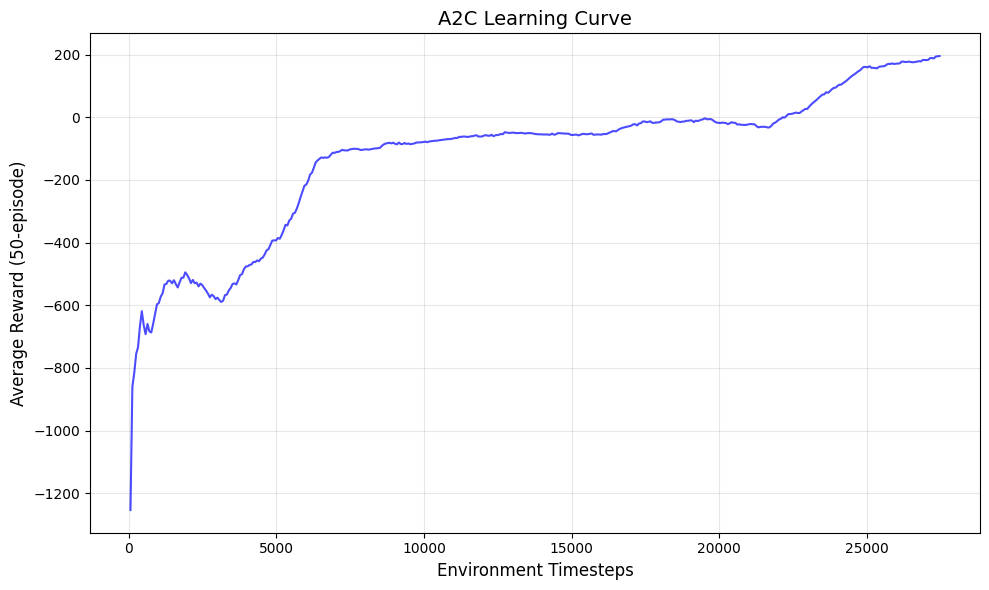

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(timesteps_log, rewards_log, linewidth=1.5, color='blue', alpha=0.7)
plt.xlabel('Environment Timesteps', fontsize=12)
plt.ylabel('Average Reward (50-episode)', fontsize=12)
plt.title('A2C Learning Curve', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
run_test(1, ac_net, True)

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  98%|█████████▊| 388/396 [00:02<00:00, 111.19it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1770153733.1339843.mp4, 720000 bytes wanted but 0 bytes read,at frame 395/396, at time 13.17/13.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


np.float64(286.65622711123933)